In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from bnr_ml.nnet import layers
from bnr_ml.objectdetect import yolo
from bnr_ml.nnet.updates import momentum
import theano
from theano import tensor as T
from collections import OrderedDict
from tqdm import tqdm

import lasagne
import lasagne.layers as layers

import pdb

In [3]:
def gen_num_objs(max_obj):
    return int(1 + max_obj * np.random.rand())

In [4]:
def gen_classes(num_obj, num_class):
    return np.random.randint(num_class, size=(num_obj,))

In [5]:
def gen_circle(shape):
#     pdb.set_trace()
    row, col = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    row, col = row.astype(np.float64), col.astype(np.float64)
    row = (row - row.shape[1] / 2) / (row.shape[1] / 2)
    col = (col - col.shape[0] / 2) / (col.shape[0] / 2)
    
    
    im = np.zeros(shape + (3,))
    for i in range(3):
        in_ellipse = (row**2 + col**2) < 1
#         im[:,:,i][in_ellipse] = (np.random.gamma(.7) + np.random.gamma(.4) * np.random.randn(*shape))[in_ellipse]
        im[:,:,i][in_ellipse] = np.ones(shape)[in_ellipse]
    im[im < 0] = 0.
    im[im >= 1] = 1.
    return im

In [6]:
def gen_rect(shape):
    im = np.zeros(shape + (3,))
    for i in range(3):
        im[:,:,i] = (np.random.gamma(.7) + np.random.gamma(.4) * np.random.randn(*shape))
    im[im < 0] = 0.
    im[im > 1] = 1.
    return im

In [7]:
def gen_triangle(shape):
    row, col = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    row, col = row.astype(np.float64), col.astype(np.float64)
    row = row / row.shape[1]
    col = col / col.shape[0]
    
    
    im = np.zeros(shape + (3,))
    if np.random.rand() < .5:
        in_triangle = row + col < 1
    else:
        in_triangle = row + col > 1
    for i in range(3):
        im[:,:,i][in_triangle] = np.ones(shape)[in_triangle]
#         im[:,:,i][in_triangle] = (np.random.gamma(.7) + np.random.gamma(.4) * np.random.randn(*shape))[in_triangle]
    im[im < 0] = 0.
    im[im >= 1] = 1.
    return im

In [8]:
def gen_pos_shape(min_shape, im_shape):
    shape = (
        int(min_shape[0] + (im_shape[0] - min_shape[0]) * np.random.rand()),
        int(min_shape[1] + (im_shape[1] - min_shape[1]) * np.random.rand())
    )
    pos = (
        int((im_shape[0] - shape[0]) * np.random.rand()),
        int((im_shape[1] - shape[1]) * np.random.rand())
    )
    return shape, pos

In [9]:
def gen_scene(max_obj, num_class, min_shape, im_shape):
    num_obj = gen_num_objs(max_obj)
    classes = gen_classes(num_obj, num_class)
    im = np.random.gamma(.4) * np.random.randn(*(im_shape + (3,)))
    im[im < 0] = 0.
    im[im > 1] = 1.
    y = np.zeros((4 + num_class,))
    
    for cls in classes:
        shape, pos = gen_pos_shape(min_shape, im_shape)
        y[:4] = pos + shape
        y[-num_class + cls] += 1.
        if cls == 0:
            shp = gen_circle(shape)
        elif cls == 1:
            shp = gen_triangle(shape)
        elif cls == 2:
            shp = gen_triangle(shape)
        else:
            pass
        im[pos[0]:pos[0]+shape[0],pos[1]:pos[1]+shape[1],:] += shp
    return im / np.max(im), y

In [10]:
def gen_dataset(size):
    X, y = np.zeros((size,3,200,200)), np.zeros((size,4+2))
    for i in range(size):
        dat = gen_scene(1, 2, (150,150), (200,200))
        X[i], y[i] = dat[0].swapaxes(2,1).swapaxes(1,0), dat[1]
    return X, y

In [11]:
X,y = gen_dataset(1000)

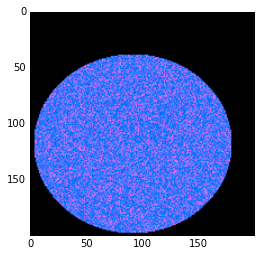

In [22]:
N = np.int_(X.shape[0] * np.random.rand())
plt.imshow(X[N].swapaxes(0,1).swapaxes(1,2))
plt.show()

In [23]:
input = T.tensor4('input')

In [27]:
l1 = layers.InputLayer((None,3,200,200), input_var=input)
l2 = layers.Conv2DLayer(
    l1,
    16,
    (3,3)
)
l3 = layers.Conv2DLayer(
    l2,
    16,
    (3,3)
)
l4 = layers.Pool2DLayer(
    l3,
    (2,2)
)
# l5 = layers.Conv2DLayer(
#     l4,
#     16,
#     (3,3)
# )
# l6 = layers.Conv2DLayer(
#     l5,
#     16,
#     (3,3)
# )
# l7 = layers.Pool2DLayer(
#     l6,
#     (2,2)
# )
l8 = layers.DenseLayer(
    layers.dropout(l4, p=.5),
    1024
)
l9 = layers.DenseLayer(
    l8,
    2,
    nonlinearity=lasagne.nonlinearities.softmax
)

In [ ]:
# pretrain
target = T.matrix('target')

def cross_ent(output, target):
    return - T.sum(target * T.log(output), axis=1).mean()

label1 = layers.get_output(l9, deterministic=False)
label2 = layers.get_output(l9, deterministic=True)

cost = cross_ent(label1, target)
cost2 = cross_ent(label2, target)

params = layers.get_all_params(l9)

grads = T.grad(cost, params)

updates = momentum(cost, params, lr=1e-4)

train_fn = theano.function([input, target], cost, updates=updates)
test_fn = theano.function([input, target], cost2)

In [ ]:
np.random.seed(1991)

N = np.int_(.95 * X.shape[0])
Xtrain, ytrain = X[:N], y[:N,-2:]
Xtest, ytest = X[N:], y[N:,-2:]

idx = np.arange(N)

epochs = 20
batch_size=40

train_cost = []
test_cost = []

for epoch in range(epochs):
    batch_cost = []
    np.random.shuffle(idx)
    Xtrain, ytrain = Xtrain[idx], ytrain[idx]
    for i in tqdm(range(0,Xtrain.shape[0],batch_size)):
        Xbatch,ybatch = Xtrain[i*batch_size:(i+1)*batch_size], ytrain[i*batch_size:(i+1)*batch_size]
        if Xbatch.shape[0] > 0:
            err =  train_fn(Xbatch, ybatch)
            batch_cost.append(err)
    train_cost.append(np.mean(batch_cost))
    test_cost.append(test_fn(Xtest,ytest))
    print('Training error: %.4f, Test eror: %.4f' % (train_cost[epoch], test_cost[epoch]))

Training error: 0.7024, Test eror: 0.6756
Training error: 0.7039, Test eror: 0.6622


Training error: 0.6896, Test eror: 0.6473

  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
reload(layers)
reload(yolo)

In [ ]:
yl = yolo.YoloObjectDetector(net, (None,3,200,200), 3, (2,2), 2)

In [ ]:
yl.train(
    X,
    y,
    lr=1e-2
)

In [ ]:
pred_fn = theano.function([yl.input], yl.output)

In [ ]:
Xval,yval = gen_dataset(50)

In [ ]:
yval[:2]

In [ ]:
pred_fn(Xval[:2])